# 第5章 误差反向传播法


要正确理解误差反向传播法，我个人认为有两种方法：一种是基于数学式； 另一种是基于计算图（computational graph）。前者是比较常见的方法，机器 学习相关的图书中多数都是以数学式为中心展开论述的。因为这种方法严密 且简洁，所以确实非常合理，但如果一上来就围绕数学式进行探讨，会忽略 一些根本的东西，止步于式子的罗列。因此，本章希望大家通过计算图，直 观地理解误差反向传播法。然后，再结合实际的代码加深理解，相信大家一 定会有种“原来如此！”的感觉。

### 5.4.1　乘法层的实现


层的实现中有两个共通的方法（接口）forward()和backward()。forward() 对应正向传播，backward()对应反向传播。 

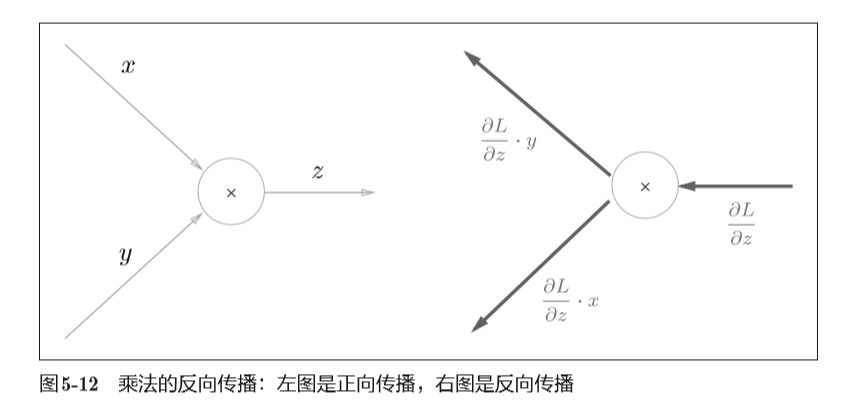

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self,x,y):
        self.x = x
        self.y = y
        out = x*y
        return out
    
    def backward(self,dout):
        dx = dout * self.y
        dy = dout*self.x
        return dx,dy

__init__()中会初始化实例变量x和y，它们用于保存正向传播时的输入值。 forward()接收x和y两个参数，将它们相乘后输出。backward()将从上游传 来的导数（dout）乘以正向传播的翻转值，然后传给下游。

上面就是MulLayer的实现。现在我们使用MulLayer实现前面的购买苹果 的例子（2个苹果和消费税）

In [2]:
apple = 100
apple_num = 2
tax = 1.1

In [3]:
#layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

In [4]:
#forward
apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

In [5]:
price

220.00000000000003

In [6]:
#backward
dprice = 1
dapple_price ,dtax = mul_tax_layer.backward(dprice)
dapple,dapple_num = mul_apple_layer.backward(dapple_price)

In [7]:
print(dapple,dapple_num,dtax)

2.2 110.00000000000001 200


这里，调用backward()的顺序与调用forward()的顺序相反。此外，要注 意backward()的参数中需要输入“关于正向传播时的输出变量的导数”。比如， mul_apple_layer乘法层在正向传播时会输出apple_price，在反向传播时，则 会将apple_price的导数dapple_price设为参数。

### 5.4.2　加法层的实现


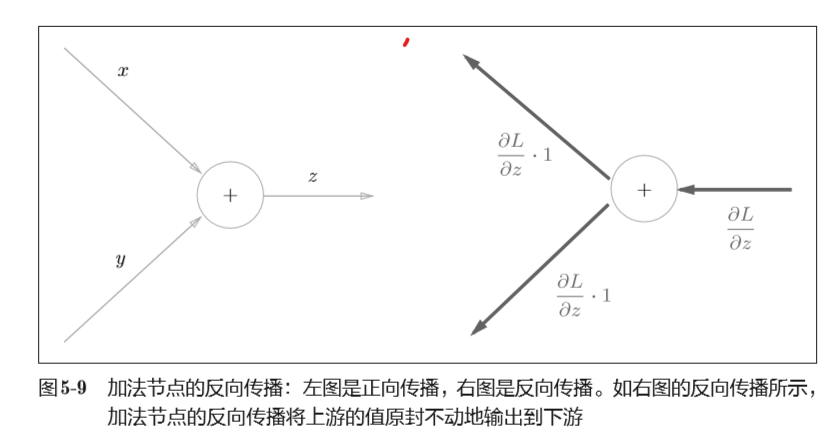

In [8]:
class AddLayer:
    def __init__(self):
        pass
    def forward(self,x,y):
        out = x+y
        return out
    def backward(self,dout):
        dx = dout*1
        dy = dout*1
        return dx,dy

加法层不需要特意进行初始化，所以__init__()中什么也不运行（pass 语句表示“什么也不运行”）。加法层的forward()接收x和y两个参数，将它 们相加后输出。backward()将上游传来的导数（dout）原封不动地传递给下游。 

现在，我们使用加法层和乘法层，实现图5-17所示的购买2个苹果和3 个橘子的例子

In [10]:
apple = 100 
apple_num = 2 
orange = 150 
orange_num = 3
tax = 1.1
# layer 
mul_apple_layer = MulLayer() 
mul_orange_layer = MulLayer() 
add_apple_orange_layer = AddLayer() 
mul_tax_layer = MulLayer()
# forward 
apple_price = mul_apple_layer.forward(apple, apple_num) #(1) 
orange_price = mul_orange_layer.forward(orange, orange_num) #(2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price) #(3) 
price = mul_tax_layer.forward(all_price, tax) #(4)
# backward 
dprice = 1 dall_price, dtax = mul_tax_layer.backward(dprice) #(4) 
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price) #(3) 
dorange, dorange_num = mul_orange_layer.backward(dorange_price) #(2) 
dapple, dapple_num = mul_apple_layer.backward(dapple_price) #(1)
print(price) # 715 
print(dapple_num, dapple, dorange, dorange_num, dtax) # 110 2.2 3.3 165 650


SyntaxError: invalid syntax (<ipython-input-10-7abc0d8cdfe5>, line 17)

这个实现稍微有一点长，但是每一条命令都很简单。首先，生成必要的 层，以合适的顺序调用正向传播的forward()方法。然后，用与正向传播相 反的顺序调用反向传播的backward()方法，就可以求出想要的导数。 综上，计算图中层的实现（这里是加法层和乘法层）非常简单，使用这 些层可以进行复杂的导数计算。下面，我们来实现神经网络中使用的层。


## 5.5 激活函数层的实现

### 5.5.1　ReLU层


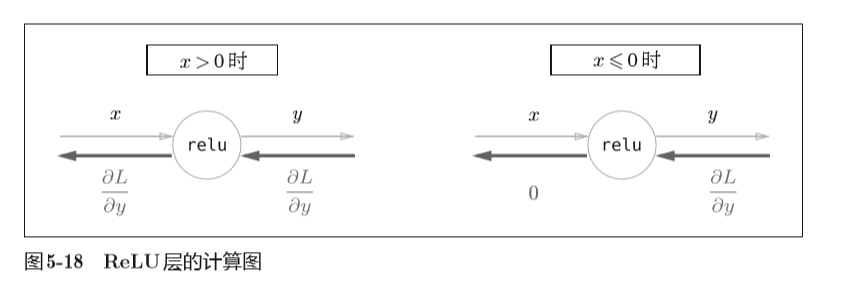

In [11]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        return dx

Relu类有实例变量mask。这个变量mask是由True/False构成的NumPy数 组，它会把正向传播时的输入x的元素中小于等于0的地方保存为True，其 他地方（大于0的元素）保存为False。如下例所示，mask变量保存了由True/ False构成的NumPy数组。


In [13]:
import numpy as np
x = np.array([[1.0,-0.5],[-2.0,3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [15]:
mask = (x<=0)
mask

array([[False,  True],
       [ True, False]])

如果正向传播时的输入值小于等于0，则反向传播的值为0。 因此，反向传播中会使用正向传播时保存的mask，将从上游传来的dout的 mask中的元素为True的地方设为0。


In [18]:
out = x.copy()
out

array([[ 1. , -0.5],
       [-2. ,  3. ]])

In [20]:
out[mask] = 0
out

array([[1., 0.],
       [0., 3.]])

ReLU层的作用就像电路中的开关一样。正向传播时，有电流通过 的话，就将开关设为ON；没有电流通过的话，就将开关设为OFF。 反向传播时，开关为ON的话，电流会直接通过；开关为OFF的话， 则不会有电流通过。


### 5.5.2　Sigmoid层


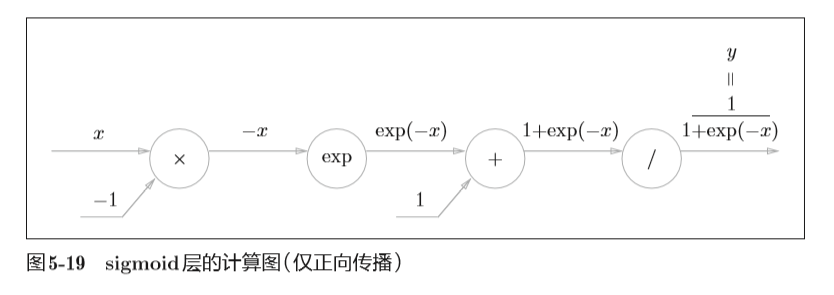

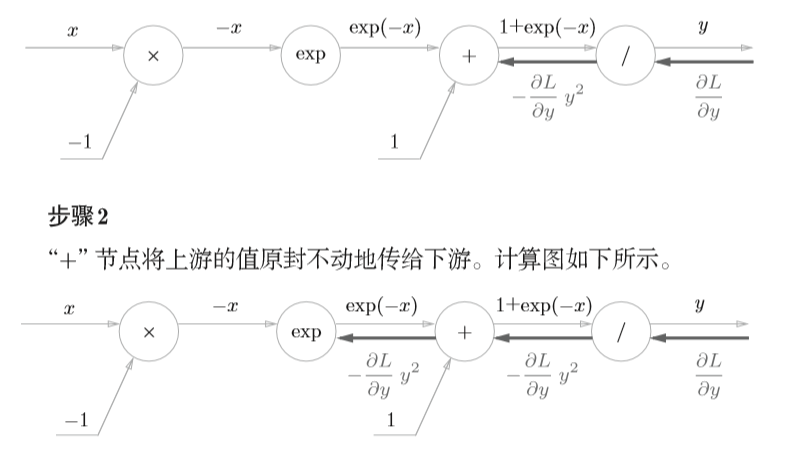

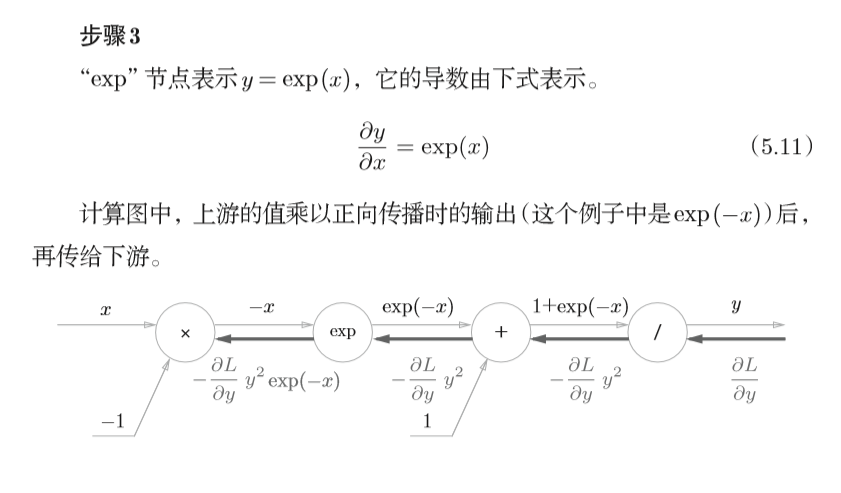

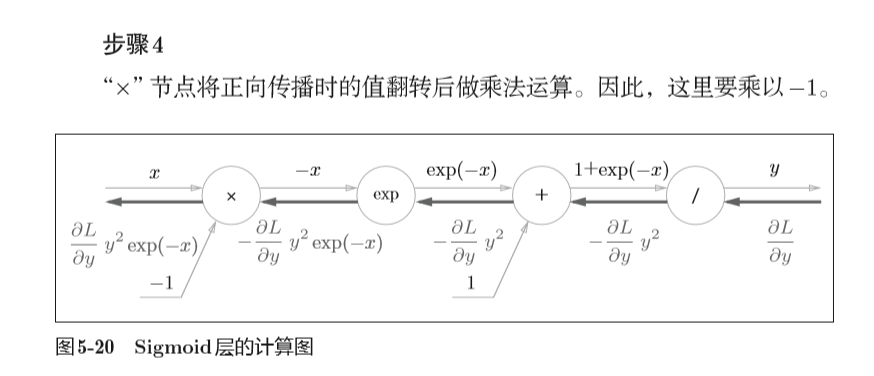

根据上述内容，图5-20的计算图可以进行Sigmoid层的反向传播。从图5-20 的结果可知，反向传播的输出为 ，这个值会传播给下游的节点。 这里要注意， 这个值只根据正向传播时的输入x和输出y就可 以算出来。因此，图5-20的计算图可以画成图5-21的集约化的“sigmoid”节点。


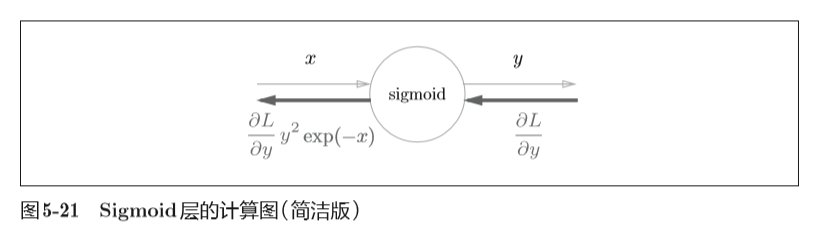

图5-20的计算图和简洁版的图5-21的计算图的计算结果是相同的，但是， 简洁版的计算图可以省略反向传播中的计算过程，因此计算效率更高。此外， 通过对节点进行集约化，可以不用在意Sigmoid层中琐碎的细节，而只需要 专注它的输入和输出，这一点也很重要。

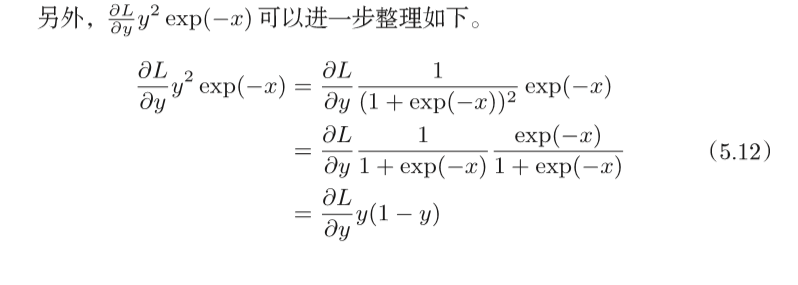

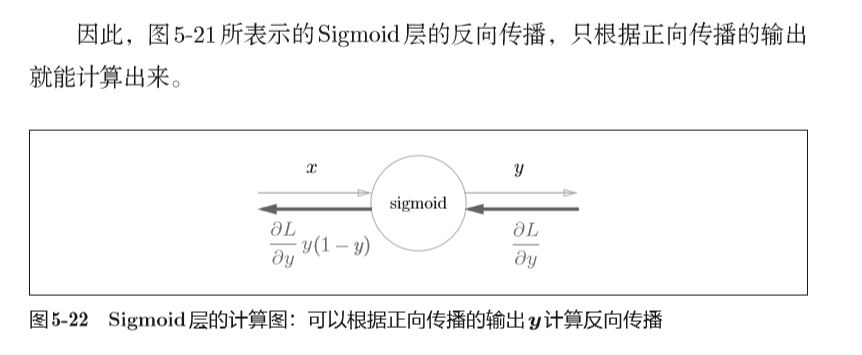

In [21]:
class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self,x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out
    def backward(self,dout):
        dx = dout*(1.0 - self.out)*self.out
        return dx

这个实现中，正向传播时将输出保存在了实例变量out中。然后，反向 传播时，使用该变量out进行计算。


## 5.6 Affine/Softmax层的实现


### 5.6.1　Affine层


神经网络的正向传播中，为了计算加权信号的总和，使用了矩阵的乘 积运算

In [22]:
X = np.random.rand(2)   # 输入
W = np.random.rand(2,3) # 权重 
B = np.random.rand(3)   # 偏置
X.shape # (2,) 
W.shape # (2, 3) 
B.shape # (3,) 
Y = np.dot(X, W) + B


这里，X、W、B 分别是形状为(2,)、(2,3)、(3,)的多维数组。这样一 来，神经元的加权和可以用Y = np.dot(X, W) + B计算出来。然后，Y 经过 激活函数转换后，传递给下一层。这就是神经网络正向传播的流程。此外， 我们来复习一下，矩阵的乘积运算的要点是使对应维度的元素个数一致。比 如，如下面的图5-23所示，X和W 的乘积必须使对应维度的元素个数一致。 另外，这里矩阵的形状用(2, 3)这样的括号表示（为了和NumPy的shape属 性的输出一致）。


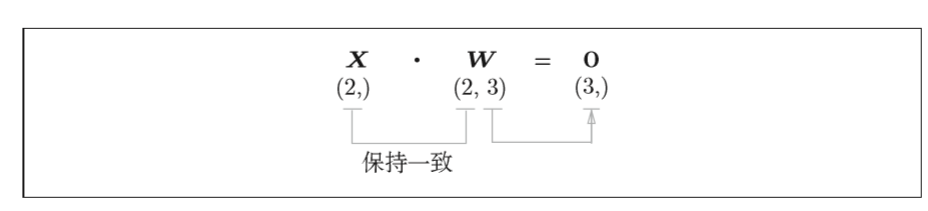

神经网络的正向传播中进行的矩阵的乘积运算在几何学领域被称为“仿 射变换” A

几何中，仿射变换包括一次线性变换和一次平移，分别对应神经网络的加权和运算与加偏置运算

现在将这里进行的求矩阵的乘积与偏置的和的运算用计算图表示出来。 将乘积运算用“dot”节点表示的话，则np.dot(X, W) + B的运算可用图5-24 所示的计算图表示出来。另外，在各个变量的上方标记了它们的形状（比如， 计算图上显示了X的形状为(2,)，X·W的形状为(3,)等）。


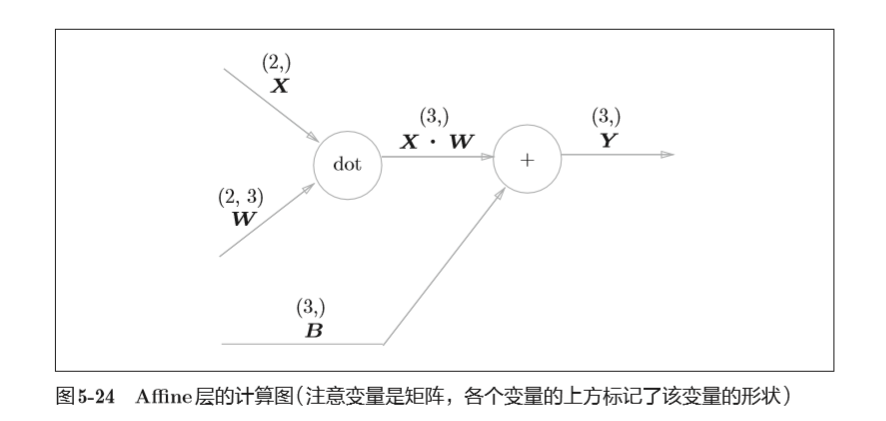

图5-24是比较简单的计算图，不过要注意X、W、B是矩阵（多维数组）。 之前我们见到的计算图中各个节点间流动的是标量，而这个例子中各个节点 间传播的是矩阵。 

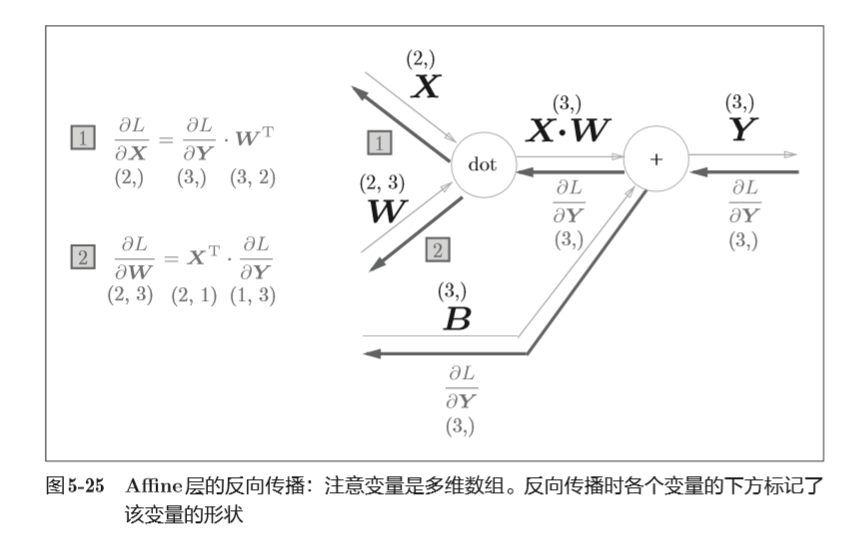

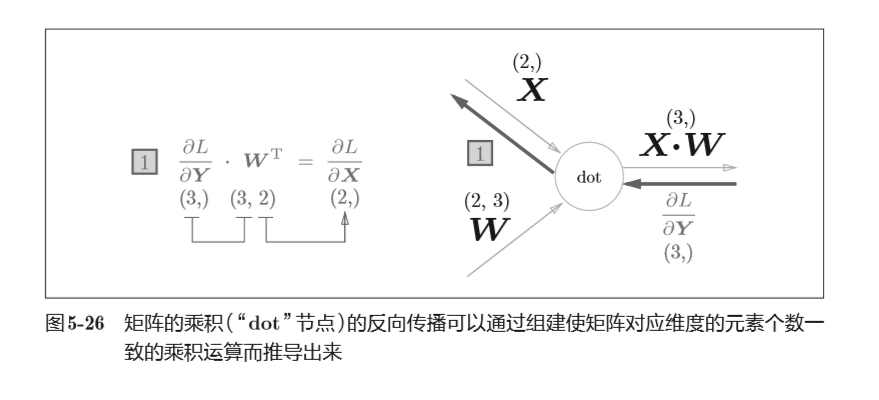

### 5.6.2　批版本的Affine层


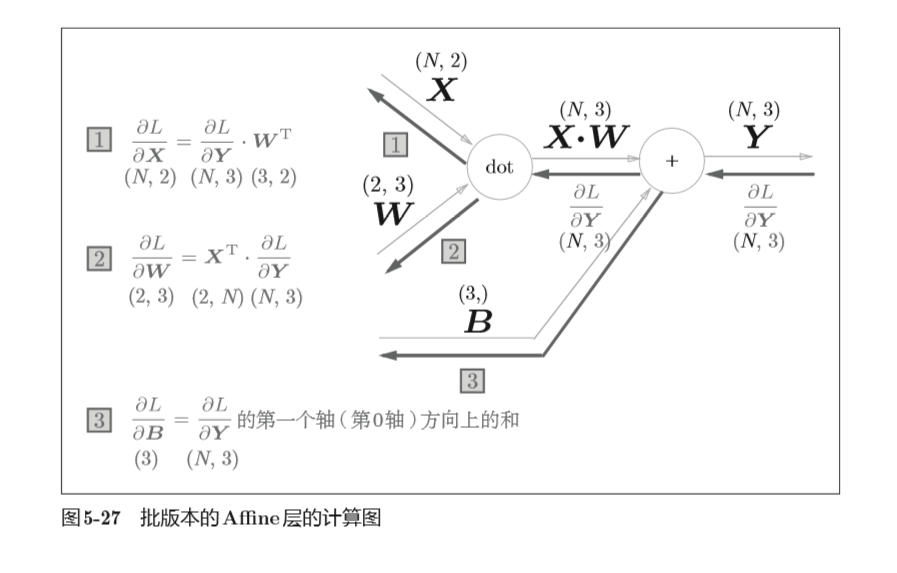!

与刚刚不同的是，现在输入X的形状是(N,2)。之后就和前面一样，在 计算图上进行单纯的矩阵计算。反向传播时，如果注意矩阵的形状，就可以 和前面一样推导出 和 。 

加上偏置时，需要特别注意。正向传播时，偏置被加到X·W的各个 数据上。比如，N = 2（数据为2个）时，偏置会被分别加到这2个数据（各自 的计算结果）上，具体的例子如下所示。


In [24]:
x_dot_w = np.array([[0,0,0],[10,10,10]])
B = np.array([1,2,3])

In [25]:
x_dot_w

array([[ 0,  0,  0],
       [10, 10, 10]])

In [26]:
x_dot_w + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [27]:
class Affine:
    def __init__(self,w,b):
        self.w = w
        self.b = b
        self.x = None
        self.dw = None
        self.db = None
        
    def forward(self,x):
        self.x = x
        out = np.dot(x,w) + b
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.w.T)
        self.dw = np.dot(self.x.T * dout)
        self.db = np.sum(dout,axis = 0)
        
        return dx

### 5.6.3　Softmax-with-Loss 层


最后介绍一下输出层的softmax函数。前面我们提到过，softmax函数 会将输入值正规化之后再输出。比如手写数字识别时，Softmax层的输出如 图5-28所示。


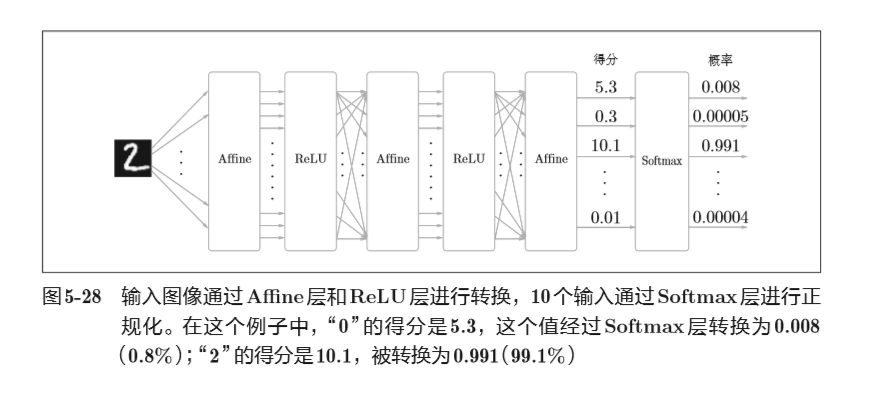

在图5-28中，Softmax层将输入值正规化（将输出值的和调整为1）之后 再输出。另外，因为手写数字识别要进行10类分类，所以向Softmax层的输 入也有10个。

神经网络中进行的处理有推理（inference）和学习两个阶段。神经网 络的推理通常不使用Softmax层。比如，用图5-28的网络进行推理时， 会将最后一个Affine层的输出作为识别结果。神经网络中未被正规 化的输出结果（图5-28中Softmax层前面的Affine层的输出）有时 被称为“得分”。也就是说，当神经网络的推理只需要给出一个答案 的情况下，因为此时只对得分最大值感兴趣，所以不需要Softmax层。 不过，神经网络的学习阶段则需要Softmax层。


下面来实现Softmax层。考虑到这里也包含作为损失函数的交叉熵误 差（cross entropy error），所以称为“Softmax-with-Loss层”。 Softmax-withLoss层（Softmax函数和交叉熵误差）的计算图如图5-29所示。


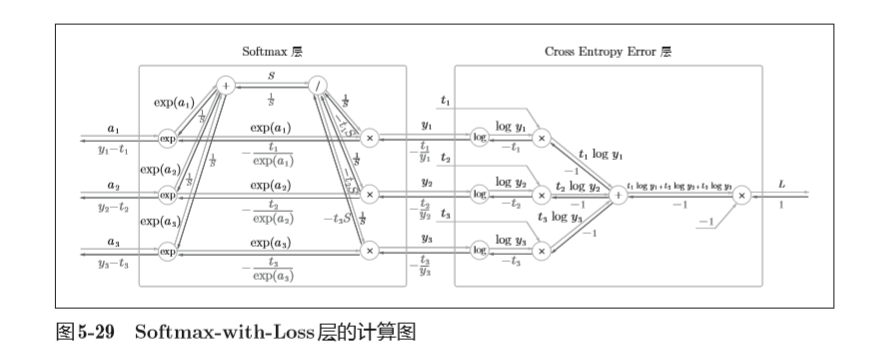

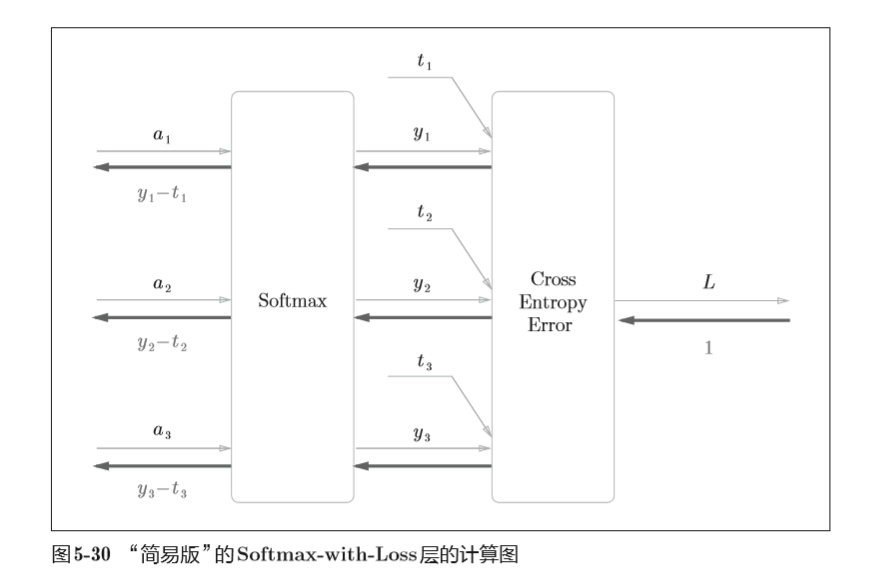

图5-30中要注意的是反向传播的结果。Softmax层的反向传播得到了 （y1 −t1,y 2 −t2,y 3 −t3）这样“漂亮”的结果。由于（y1,y 2,y 3）是 Softmax层的 输出，（ t1,t 2,t 3）是监督数据，所以（y1 −t1,y 2 −t2,y 3 −t3）是 Softmax层的输 出和监督标签的差分。神经网络的反向传播会把这个差分表示的误差传递给 前面的层，这是神经网络学习中的重要性质。 

神经网络学习的目的就是通过调整权重参数，使神经网络的输出（Softmax 的输出）接近监督标签。因此，必须将神经网络的输出与监督标签的误差高 效地传递给前面的层。刚刚的（y1 −t1,y 2 −t2,y 3 −t3）正是 Softmax层的输出 与监督标签的差，直截了当地表示了当前神经网络的输出与监督标签的误差。

这里考虑一个具体的例子，比如思考监督标签是（0,1,0）， Softmax层 的输出是(0.3, 0.2, 0.5)的情形。因为正确解标签处的概率是0.2（20%），这个 时候的神经网络未能进行正确的识别。此时，Softmax层的反向传播传递的 是(0.3,−0.8,0.5)这样一个大的误差。因为这个大的误差会向前面的层传播， 所以Softmax层前面的层会从这个大的误差中学习到“大”的内容。

使用交叉熵误差作为softmax函数的损失函数后，反向传播得到 （y1 − t1, y2 − t2, y3 − t3）这样 “漂亮”的结果。实际上，这样“漂亮” 的结果并不是偶然的，而是为了得到这样的结果，特意设计了交叉 熵误差函数。回归问题中输出层使用“恒等函数”，损失函数使用 “平方和误差”，也是出于同样的理由（3.5节）。也就是说，使用“平 方和误差”作为“恒等函数”的损失函数，反向传播才能得到（y1 − t1, y2 − t2, y3 − t3）这样“漂亮”的结果。


再举一个例子，比如思考监督标签是(0,1,0)，Softmax层的输出是(0.01, 0.99, 0)的情形（这个神经网络识别得相当准确）。此时Softmax层的反向传播 传递的是(0.01,−0.01, 0)这样一个小的误差。这个小的误差也会向前面的层 传播，因为误差很小，所以Softmax层前面的层学到的内容也很“小”。 

In [29]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)
        return self.loss
    def backward(self,dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) /batch_size
        return dx

这个实现利用了3.5.2节和4.2.4节中实现的softmax()和cross_entropy_ error()函数。因此，这里的实现非常简单。请注意反向传播时，将要传播 的值除以批的大小（batch_size）后，传递给前面的层的是单个数据的误差。

## 5.7 误差反向传播法的实现


通过像组装乐高积木一样组装上一节中实现的层，可以构建神经网络。 本节我们将通过组装已经实现的层来构建神经网络。


### 5.7.1　神经网络学习的全貌图


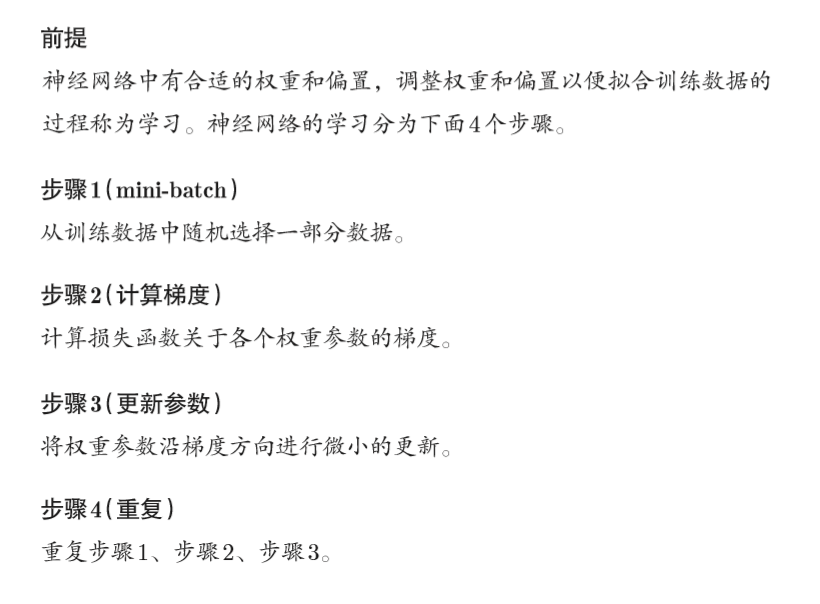

之前介绍的误差反向传播法会在步骤2中出现。上一章中，我们利用数 值微分求得了这个梯度。数值微分虽然实现简单，但是计算要耗费较多的时 间。和需要花费较多时间的数值微分不同，误差反向传播法可以快速高效地 计算梯度。


### 5.7.2　对应误差反向传播法的神经网络的实现


现在来进行神经网络的实现。这里我们要把2层神经网络实现为TwoLayerNet。 首先，将这个类的实例变量和方法整理成表5-1和表5-2。


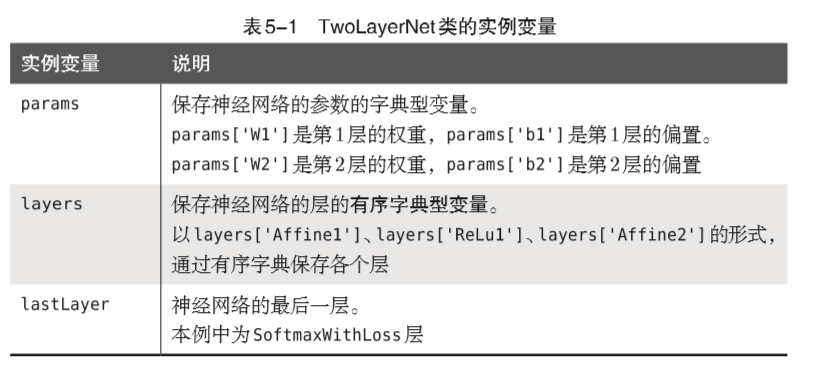

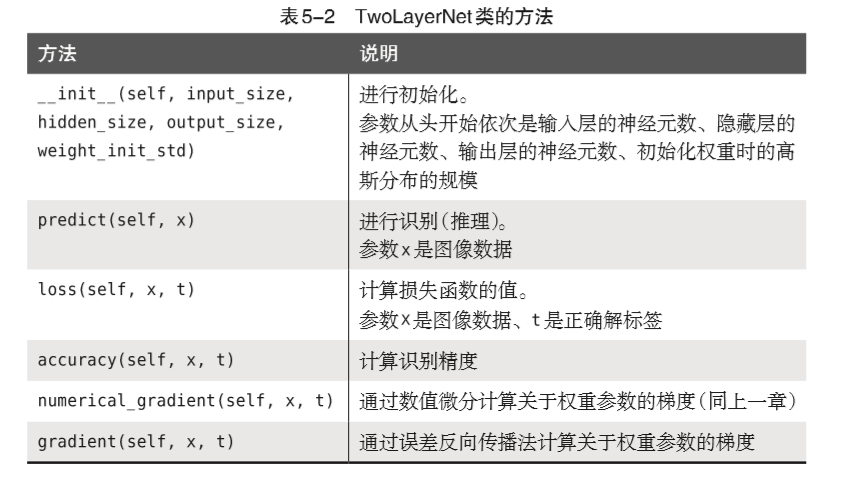

这个类的实现稍微有一点长，但是内容和4.5节的学习算法的实现有很 多共通的部分，不同点主要在于这里使用了层。通过使用层，获得识别结果 的处理（predict()）和计算梯度的处理（gradient()）只需通过层之间的传递就能完成。下面是TwoLayerNet的代码实现。


In [31]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


请注意这个实现中的粗体字代码部分，尤其是将神经网络的层保存为 OrderedDict这一点非常重要。OrderedDict是有序字典，“有序”是指它可以 记住向字典里添加元素的顺序。因此，神经网络的正向传播只需按照添加元 素的顺序调用各层的forward()方法就可以完成处理，而反向传播只需要按 照相反的顺序调用各层即可。因为Affine层和ReLU层的内部会正确处理正 向传播和反向传播，所以这里要做的事情仅仅是以正确的顺序连接各层，再 按顺序（或者逆序）调用各层。


像这样通过将神经网络的组成元素以层的方式实现，可以轻松地构建神 经网络。这个用层进行模块化的实现具有很大优点。因为想另外构建一个神 经网络（比如5层、10层、20层……的大的神经网络）时，只需像组装乐高 积木那样添加必要的层就可以了。之后，通过各个层内部实现的正向传播和 反向传播，就可以正确计算进行识别处理或学习所需的梯度。


### 5.7.3　误差反向传播法的梯度确认


到目前为止，我们介绍了两种求梯度的方法。一种是基于数值微分的方 法，另一种是解析性地求解数学式的方法。后一种方法通过使用误差反向传 播法，即使存在大量的参数，也可以高效地计算梯度。因此，后文将不再使 用耗费时间的数值微分，而是使用误差反向传播法求梯度。

数值微分的计算很耗费时间，而且如果有误差反向传播法的（正确的） 实现的话，就没有必要使用数值微分的实现了。那么数值微分有什么用呢？ 实际上，在确认误差反向传播法的实现是否正确时，是需要用到数值微分的。 

数值微分的优点是实现简单，因此，一般情况下不太容易出错。而误差 反向传播法的实现很复杂，容易出错。所以，经常会比较数值微分的结果和 误差反向传播法的结果，以确认误差反向传播法的实现是否正确。确认数值 微分求出的梯度结果和误差反向传播法求出的结果是否一致（严格地讲，是 非常相近）的操作称为梯度确认（gradient check）。梯度确认的代码实现如下 所示（源代码在ch05/gradient_check.py中）。


In [34]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:4.9635220092521e-10
b1:3.1543712067009067e-09
W2:6.609155112051569e-09
b2:1.3977394877628946e-07


和以前一样，读入MNIST数据集。然后，使用训练数据的一部分，确 认数值微分求出的梯度和误差反向传播法求出的梯度的误差。这里误差的计 算方法是求各个权重参数中对应元素的差的绝对值，并计算其平均值。运行 上面的代码后，会输出如下结果。


从这个结果可以看出，通过数值微分和误差反向传播法求出的梯度的差 非常小。比如，第1层的偏置的误差是9.7e-13（0.00000000000097）。这样一来， 我们就知道了通过误差反向传播法求出的梯度是正确的，误差反向传播法的 实现没有错误。


In [35]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.17656666666666668 0.1774
0.9047166666666666 0.9081
0.9217833333333333 0.923
0.9347333333333333 0.9338
0.9439333333333333 0.94
0.9494 0.9448
0.9557166666666667 0.9516
0.9596333333333333 0.9546
0.9624333333333334 0.9543
0.96675 0.9605
0.96815 0.9587
0.9687833333333333 0.9634
0.9726 0.9652
0.9743833333333334 0.9653
0.9759 0.968
0.9774833333333334 0.9692
0.97765 0.9669


## 5.8 小结


本章我们介绍了将计算过程可视化的计算图，并使用计算图，介绍了神 经网络中的误差反向传播法，并以层为单位实现了神经网络中的处理。我们 学过的层有ReLU层、Softmax-with-Loss层、Affine层、Softmax层等，这 些层中实现了forward和backward方法，通过将数据正向和反向地传播，可 以高效地计算权重参数的梯度。通过使用层进行模块化，神经网络中可以自 由地组装层，轻松构建出自己喜欢的网络。


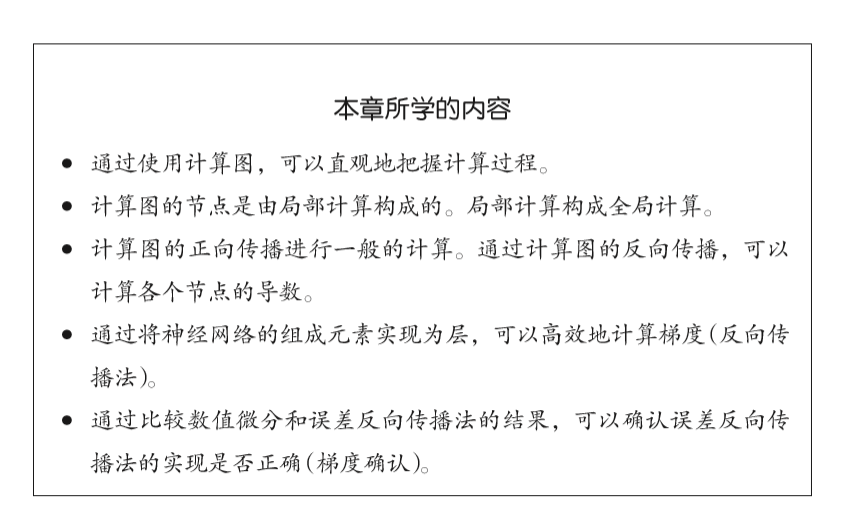